<a href="https://colab.research.google.com/github/ernestojr-7/transfer-learning-comparation/blob/main/cat_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dowload dataset

In [1]:
!ls

sample_data


In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-10-24 14:35:55--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.124.12.193, 2600:1407:7800:18e::317f, 2600:1407:7800:1a9::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.124.12.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   115MB/s    in 7.3s    

2022-10-24 14:36:02 (108 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [3]:
!unzip kagglecatsanddogs_5340.zip 

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/55

In [4]:
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'  'Untitled Folder'


##Imports

In [34]:
import os
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
from PIL import Image
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

##Prepare dataset

In [6]:
path = '/content/PetImages'
ds = tf.keras.preprocessing.image_dataset_from_directory(path)

Found 25000 files belonging to 2 classes.


In [7]:
ds.class_names

['Cat', 'Dog']

In [8]:
for image_batch, labels_batch in ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


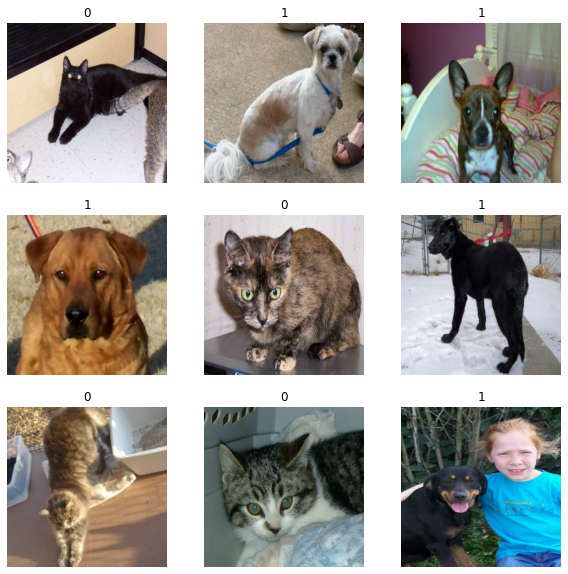

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [11]:
#Defining parameters for the loader:
batch_size = 16
img_height = 224
img_width = 224
channels = 3

In [12]:
data_dir = path
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  color_mode="rgb", 
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  color_mode="rgb", 
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [13]:
# train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [14]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

#<font color='DeepSkyBlue'>Training with transfer of learning</font>

##Prepare model

In [30]:
input_tensor = Input(shape=(img_height, img_width, channels))
model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor
      ) 
# for layer in model.layers[:len(model.layers)]:
#    layer.trainable = False

layer_1 = tf.keras.layers.GlobalMaxPool2D(
    name="global_max_pool")(model.output)
hp_units = 64
layer_2 = tf.keras.layers.Dense(hp_units, activation="relu")(layer_1)

layer_3 = tf.keras.layers.Dropout(0.7, name="Dropout")(layer_2)

outputs = tf.keras.layers.Dense(2, name='logits', activation='softmax')(layer_3)
model = tf.keras.Model(inputs=model.inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [31]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

##Train

In [32]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=10, workers=2)

Epoch 1/10
1025/1025 [==============================] - 207s 194ms/step - loss: 0.4683 - accuracy: 0.7922 - precision: 0.7922 - recall: 0.7922 - val_loss: 0.1300 - val_accuracy: 0.9547 - val_precision: 0.9547 - val_recall: 0.9547
Epoch 2/10
1025/1025 [==============================] - 189s 184ms/step - loss: 0.2411 - accuracy: 0.9004 - precision: 0.9004 - recall: 0.9004 - val_loss: 0.0853 - val_accuracy: 0.9704 - val_precision: 0.9704 - val_recall: 0.9704
Epoch 3/10
1025/1025 [==============================] - 187s 182ms/step - loss: 0.1919 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - val_loss: 0.0710 - val_accuracy: 0.9761 - val_precision: 0.9761 - val_recall: 0.9761
Epoch 4/10
1025/1025 [==============================] - 190s 185ms/step - loss: 0.1629 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - val_loss: 0.0617 - val_accuracy: 0.9792 - val_precision: 0.9792 - val_recall: 0.9792
Epoch 5/10
1025/1025 [==============================] - 194s 189ms/step - loss: 

In [60]:
import plotly.express as px
figura = px.line(title = 'validation metrics with transfer-learning')

figura.add_scatter(x = np.arange(0, 10), y = history.history['loss'], name = 'train_Loss')
figura.add_scatter(x = np.arange(0, 10), y = history.history['val_loss'], name = 'val_Loss')
figura.add_scatter(x = np.arange(0, 10), y = history.history['val_accuracy'], name = 'Accuracy')
figura.add_scatter(x = np.arange(0, 10), y = history.history['val_precision'], name = 'Precision')
figura.add_scatter(x = np.arange(0, 10), y = history.history['val_recall'], name = 'Recall')

figura.update_layout(xaxis_title='Epoch')
figura.show()

In [52]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(np.argmax(label_batch, axis = -1))
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 30ms/step


In [36]:
def plot_confusion_matrix(pred_list, rotulo_list, labels_list = None):
    cm = metrics.confusion_matrix(rotulo_list, pred_list)
    ax = sn.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False);
    if labels_list is not None:
      ax.xaxis.set_ticklabels(labels_list)
      ax.yaxis.set_ticklabels(labels_list, rotation=45)
    plt.title("CONFUSION MATRIX")
    plt.xlabel("predicted classification")
    plt.ylabel("real rating")
    plt.show()

In [38]:
predicted_labels

<tf.Tensor: shape=(7023,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1])>

In [53]:
correct_labels

<tf.Tensor: shape=(7023,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 1])>

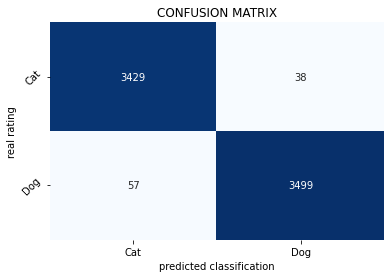

In [54]:
plot_confusion_matrix(predicted_labels, correct_labels, ['Cat', 'Dog'])

##Predict image test

In [19]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

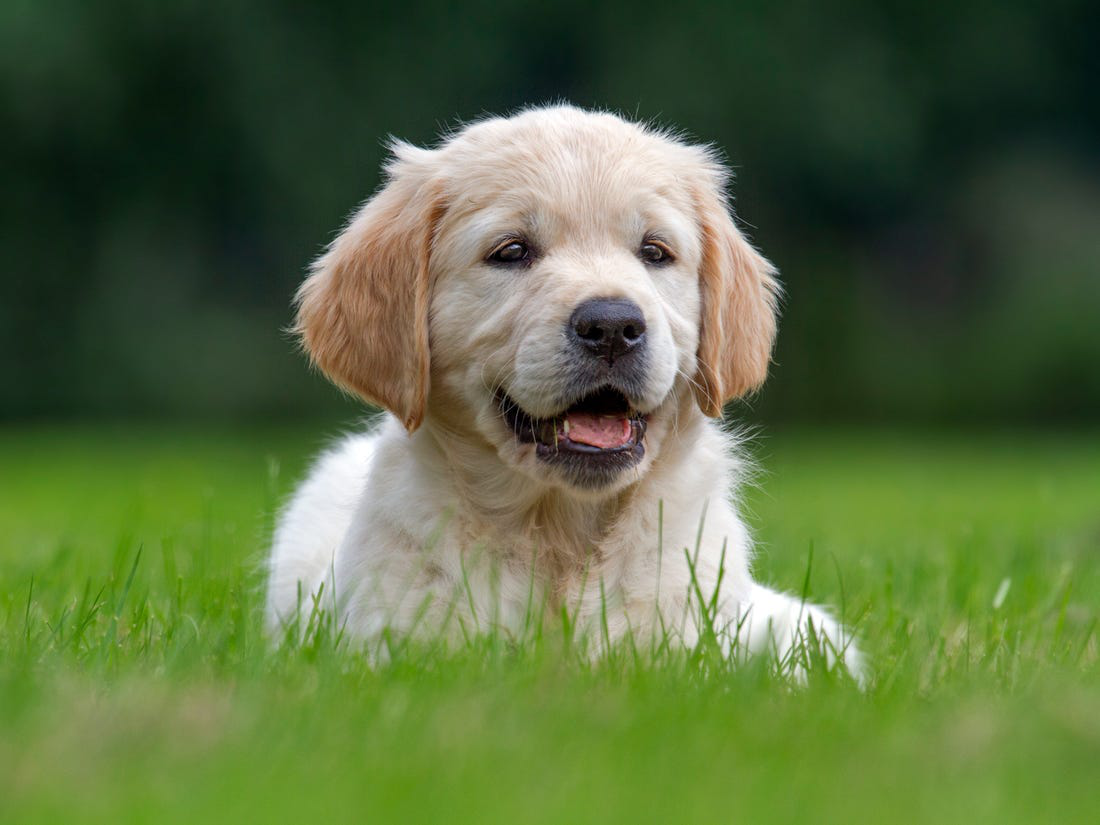

In [40]:
path_dog = '/content/teste/dog1.jpg'
Image.open(path_dog)

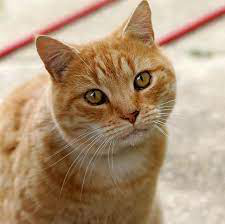

In [41]:
path_cat = '/content/teste/cat.jpeg'
Image.open(path_cat)

In [42]:
img_size = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
img_array_cat = preprocess_input(get_img_array(path_cat, size=img_size))

pred_prob = model.predict(img_array_cat)
pred = np.argmax(pred_prob)
print(f'Classification: {train_ds.class_names[pred]} with prob: {pred_prob[0][pred]*100:.2f}%')

1/1 [==============================] - 0s 27ms/step
Classification: Cat with prob: 100.00%


In [43]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
img_array_dog = preprocess_input(get_img_array(path_dog, size=img_size))

pred_prob = model.predict(img_array_dog)
pred = np.argmax(pred_prob)
print(f'Classification: {train_ds.class_names[pred]} with prob: {pred_prob[0][pred]*100:.2f}%')

1/1 [==============================] - 0s 30ms/step
Classification: Dog with prob: 100.00%


#<font color='DeepSkyBlue'>Training without transfer of learning</font>

##Prepare model

In [44]:
input_tensor = Input(shape=(img_height, img_width, channels))
model2 = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,
        weights=None,
        input_tensor=input_tensor
      ) 
model2.trainable = True
# for layer in model.layers[:int(0.5*len(model2.layers))]:
#   #  layer.trainable = False
  #  print(f'trainable: {layer.trainable }')

layer_1 = tf.keras.layers.GlobalMaxPool2D(
    name="global_max_pool")(model2.output)
hp_units = 64
layer_2 = tf.keras.layers.Dense(hp_units, activation="relu")(layer_1)

layer_3 = tf.keras.layers.Dropout(0.7, name="Dropout")(layer_2)

outputs = tf.keras.layers.Dense(2, activation='softmax')(layer_3)
model2 = tf.keras.Model(inputs=model2.inputs, outputs=outputs)
# model2.summary()

In [45]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

##Train

In [46]:
history2 = model2.fit(train_ds, validation_data=validation_ds, epochs=10, workers=2)


Epoch 1/10
1025/1025 [==============================] - 198s 185ms/step - loss: 0.7284 - accuracy: 0.5193 - precision: 0.5193 - recall: 0.5193 - val_loss: 0.6941 - val_accuracy: 0.5065 - val_precision: 0.5065 - val_recall: 0.5065
Epoch 2/10
1025/1025 [==============================] - 189s 184ms/step - loss: 0.6925 - accuracy: 0.5197 - precision: 0.5197 - recall: 0.5197 - val_loss: 0.6967 - val_accuracy: 0.5053 - val_precision: 0.5053 - val_recall: 0.5053
Epoch 3/10
1025/1025 [==============================] - 188s 184ms/step - loss: 0.6907 - accuracy: 0.5277 - precision: 0.5277 - recall: 0.5277 - val_loss: 0.6915 - val_accuracy: 0.5241 - val_precision: 0.5241 - val_recall: 0.5241
Epoch 4/10
1025/1025 [==============================] - 191s 186ms/step - loss: 0.6905 - accuracy: 0.5297 - precision: 0.5297 - recall: 0.5297 - val_loss: 0.7023 - val_accuracy: 0.5192 - val_precision: 0.5192 - val_recall: 0.5192
Epoch 5/10
1025/1025 [==============================] - 189s 184ms/step - loss: 

In [59]:
figura = px.line(title = 'validation metrics without transfer-learning')

figura.add_scatter(x = np.arange(0, 10), y = history2.history['loss'], name = 'train_Loss')
figura.add_scatter(x = np.arange(0, 10), y = history2.history['val_loss'], name = 'val_Loss')
figura.add_scatter(x = np.arange(0, 10), y = history2.history['val_accuracy'], name = 'Accuracy')
figura.add_scatter(x = np.arange(0, 10), y = history2.history['val_precision'], name = 'Precision')
figura.add_scatter(x = np.arange(0, 10), y = history2.history['val_recall'], name = 'Recall')

figura.update_layout(xaxis_title='Epoch')
figura.show()

In [57]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(np.argmax(label_batch, axis = -1))
   # compute predictions
   preds = model2.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 28ms/step


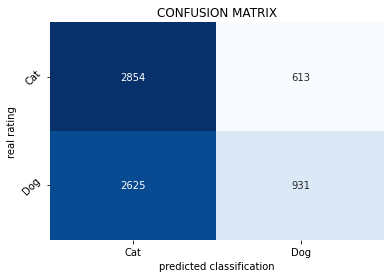

In [58]:
plot_confusion_matrix(predicted_labels, correct_labels, ['Cat', 'Dog'])

##Predict image test

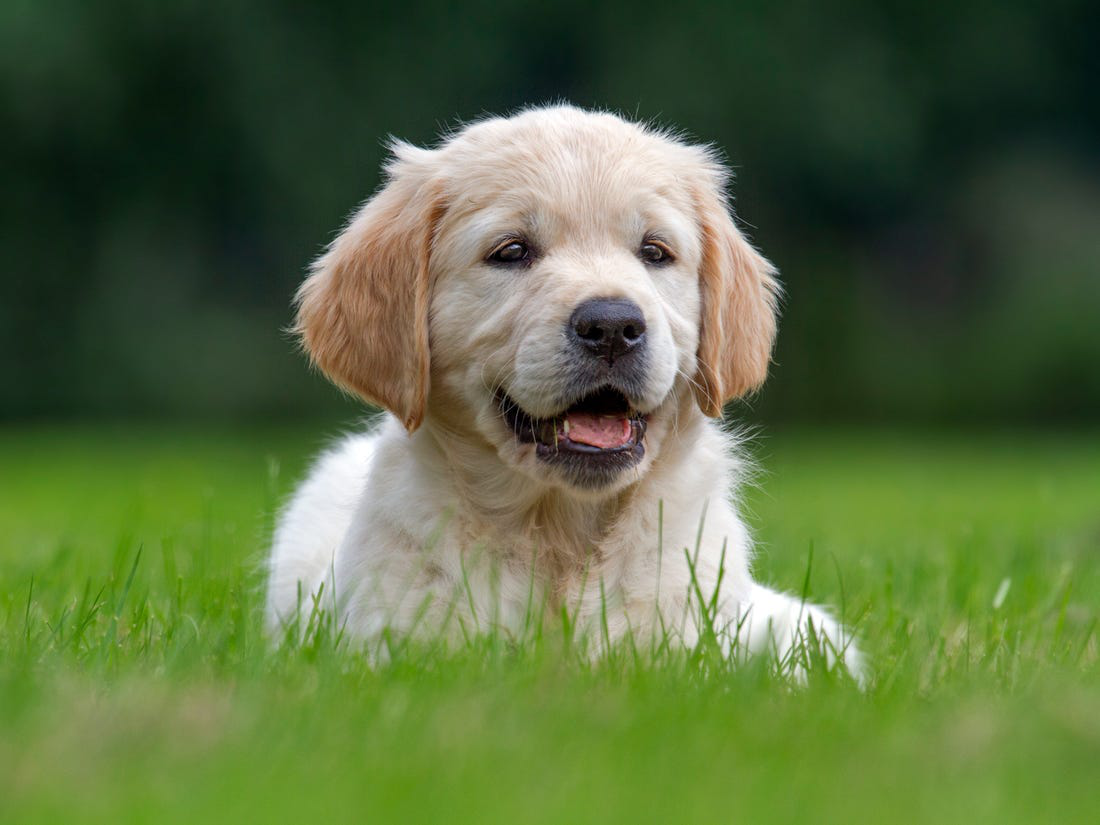

In [48]:
path_dog = '/content/teste/dog1.jpg'
Image.open(path_dog)

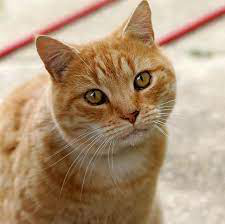

In [49]:
path_cat = '/content/teste/cat.jpeg'
Image.open(path_cat)

In [50]:
img_size = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
img_array_cat = preprocess_input(get_img_array(path_cat, size=img_size))

pred_prob = model2.predict(img_array_cat)
pred = np.argmax(pred_prob)
print(f'Classification: {train_ds.class_names[pred]} with prob: {pred_prob[0][pred]*100:.2f}%')

1/1 [==============================] - 1s 1s/step
Classification: Cat with prob: 53.16%


In [51]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
img_array_dog = preprocess_input(get_img_array(path_dog, size=img_size))

pred_prob = model2.predict(img_array_dog)
pred = np.argmax(pred_prob)
print(f'Classification: {train_ds.class_names[pred]} with prob: {pred_prob[0][pred]*100:.2f}%')

1/1 [==============================] - 0s 29ms/step
Classification: Cat with prob: 51.22%
